In [2]:
from bs4 import BeautifulSoup as bs
import requests

DOMAIN = ''
URL = 'https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page'
ext = '.parquet'

def get_soup(url):
    return bs(requests.get(url).text, 'html.parser')

input_dir = ["./train/", "./test/"]
a = ['2022-01', '2022-02', '2022-03']
b = ['2023-01', '2023-02', '2023-03']
for data_type in input_dir:
  if 'train' in data_type:
    iter_list = a
  else:
    iter_list = b
  for date in iter_list:
    FILETYPE = "yellow_tripdata_"+date + ext
    for link in get_soup(URL).find_all('a'):
        file_link = link.get('href')
        if FILETYPE in file_link:
            with open(data_type+FILETYPE, 'wb') as file:
                response = requests.get(file_link)
                file.write(response.content)
    print("Successfully downloaded the file at this location: ", data_type+FILETYPE)

Successfully downloaded the file at this location:  ./train/yellow_tripdata_2022-01.parquet
Successfully downloaded the file at this location:  ./train/yellow_tripdata_2022-02.parquet
Successfully downloaded the file at this location:  ./train/yellow_tripdata_2022-03.parquet
Successfully downloaded the file at this location:  ./test/yellow_tripdata_2023-01.parquet
Successfully downloaded the file at this location:  ./test/yellow_tripdata_2023-02.parquet
Successfully downloaded the file at this location:  ./test/yellow_tripdata_2023-03.parquet


# NYC Yellow Taxi Trip Data: Pickup Density Prediction
- Hola amigos, this notebook covers my code for the **NYC Yellow Taxi Trip Data** dataset, in which I have trained some models to **predict the pickup density**. The dataset can be found [here](https://www.kaggle.com/elemento/nyc-yellow-taxi-trip-data).
- This dataset can be used in other interesting ways as well, but I chose to use it this way. Feel free to use this dataset in other ways, and do let me know in the [Discussion Section](https://www.kaggle.com/elemento/nyc-yellow-taxi-trip-data/discussion) of the dataset. Feel free to check out the dataset for more information.
- This work is largely inspired by the **Applied AI Course**, and I would like to say a special thanks to the entire team of Applied AI.

# Installing & Importing Packages

In [4]:
!pip install gpxpy
!pip3 install pyroomacoustics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 742.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for pyroomacoustics: filename=pyroomacoustics-0.7.3-cp310-cp310-linux_x86_64.whl size=11864189 sha256=07fff027f6b5b4823d4d3c6dfdad1418f9ad9263a34082f7f0f91cf463c8100b
  Stored in directory: /root/.cache/pip/wheels/6b/f3/67/0d0c4c06234c59c14e5ccf72774bd5c5f1b43c3083043c7fb7
Successfully built pyroomacoustics


In [5]:
import os
import time
import math
import scipy
import pickle
import warnings
import datetime
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import xgboost as xgb
import matplotlib.pylab as plt
import dask.dataframe as dd
import gpxpy.geo

from matplotlib import rcParams
from datetime import datetime as dt

matplotlib.use('nbagg');
warnings.filterwarnings("ignore");
%matplotlib inline

# ML Problem Formulation
### Time-series Forecasting and Regression
- To find number of pickups, given location cordinates (latitude and longitude) and time, in the query region and surrounding regions.
-  To solve the above problem, we would be using data collected in Jan-Mar 2022 to predict the pickups in Jan-Mar 2023.

# Performance metrics
1. Mean Absolute percentage error (MAPE)
2. Mean Squared error (MSE)


# 1. Data Cleaning
- In this section we will be doing univariate analysis and removing outlier/illegitimate values which may be caused due to some error.
- We will do the entire univariate analysis on training data, and whatever pre-processing we do based on the insights, will be applied to the data from all the 6 months.

In [6]:
# Define the file pattern to match all Parquet files
file_pattern = './train/yellow_tripdata_2022-*.parquet'

# Read Parquet files into a single Dask DataFrame, specifying columns if needed
month = dd.read_parquet(file_pattern)

# Display the first few rows of the combined DataFrame
month.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [7]:
# Display last few rows of the dataframe to verify if the complete training set is loaded.
month.tail()

# Get the size of dataframe
print("Number of records in the DataFrame:", len(month))
# Get the memory usage by dataframe

# Convert memory usage to human-readable format
def sizeof_fmt(num, suffix='B'):
    for unit in ['', 'Ki', 'Mi', 'Gi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)
total_memory_usage = month.memory_usage(deep=True).sum().compute()
print("Total memory usage of the DataFrame:", sizeof_fmt(total_memory_usage))


Number of records in the DataFrame: 9071244
Total memory usage of the DataFrame: 1.7 GiB


## 1.1 Check for Missing values
Checking for Nan Values and dropping if we found any.


In [8]:
# display the missing value in form of percnetage below

missing_values = month.isnull().sum().compute()
total_values = len(month)
missing_values_percentage = (missing_values / total_values) * 100
print("Missing Values Percentage:\n", missing_values_percentage)


Missing Values Percentage:
 VendorID                 0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          3.208546
trip_distance            0.000000
RatecodeID               3.208546
store_and_fwd_flag       3.208546
PULocationID             0.000000
DOLocationID             0.000000
payment_type             0.000000
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     3.208546
airport_fee              3.208546
dtype: float64


In [9]:
#Dropping partial records rows inplace
month = month.dropna()
month.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [10]:
missing_values = month.isnull().sum().compute()
total_values = len(month)
missing_values_percentage = (missing_values / total_values) * 100
print("Missing Values Percentage:\n", missing_values_percentage)

Missing Values Percentage:
 VendorID                 0.0
tpep_pickup_datetime     0.0
tpep_dropoff_datetime    0.0
passenger_count          0.0
trip_distance            0.0
RatecodeID               0.0
store_and_fwd_flag       0.0
PULocationID             0.0
DOLocationID             0.0
payment_type             0.0
fare_amount              0.0
extra                    0.0
mta_tax                  0.0
tip_amount               0.0
tolls_amount             0.0
improvement_surcharge    0.0
total_amount             0.0
congestion_surcharge     0.0
airport_fee              0.0
dtype: float64


## 1.2 Check for Trip Duration
According to the regulations mentioned in the source data site, the maximum allowed trip duration in a 24 hour interval is 12 hours.

In the data, we have time format in "YYYY-MM-DD HH:MM:SS.MS"
We convert this string to python time format and then into unix time stamp

In [6]:
def convert_to_unix(s):
  s_str = str(s)  # Convert numpy.datetime64 to string
  # Remove microseconds part from the string
  s_str_without_microseconds = s_str.split('.')[0]
  return time.mktime(datetime.datetime.strptime(s_str_without_microseconds, "%Y-%m-%dT%H:%M:%S").timetuple())

In [7]:
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()

    # Pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]

    # Calculate the duration of trips
    # Division by 60 converts the difference from seconds to minutes
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    # Append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','total_amount', 'PULocationID', 'DOLocationID', 'pickup_longitude','pickup_latitude',
        'dropoff_longitude','dropoff_latitude']].compute()

    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])

    return new_frame


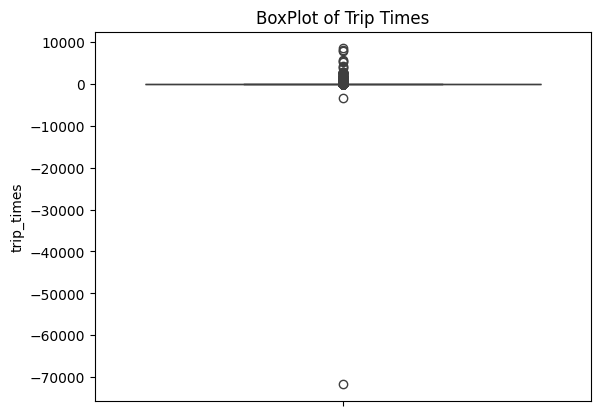

In [13]:
%matplotlib inline


# the skewed box plot shows us the presence of outliers
sns.boxplot(y="trip_times", data =month_with_duration).set(title='BoxPlot of Trip Times')
plt.show()

In [14]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =month_with_duration["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -71759.93333333333
10 percentile value is 4.283333333333333
20 percentile value is 6.0
30 percentile value is 7.583333333333333
40 percentile value is 9.216666666666667
50 percentile value is 11.016666666666667
60 percentile value is 13.133333333333333
70 percentile value is 15.833333333333334
80 percentile value is 19.683333333333334
90 percentile value is 26.883333333333333
100 percentile value is  8513.183333333332


In [15]:
for i in range(90, 100):
    var =month_with_duration["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 26.883333333333333
91 percentile value is 28.05
92 percentile value is 29.416666666666668
93 percentile value is 31.0
94 percentile value is 32.88333333333333
95 percentile value is 35.2
96 percentile value is 38.166666666666664
97 percentile value is 42.15
98 percentile value is 47.916666666666664
99 percentile value is 57.85
100 percentile value is  8513.183333333332


In [16]:
# Removing data based on our analysis and TLC regulations
month_with_durations_modified = month_with_duration[(month_with_duration.trip_times > 1) & \
    (month_with_duration.trip_times < 720)]

In [17]:
month_with_durations_modified.head()

,passenger_count,trip_distance,total_amount,PULocationID,DOLocationID,trip_times,pickup_times,Speed
0,2.0,3.80,21.95,142,236,17.816667,1.640997e+09,12.797007
1,1.0,2.10,13.30,236,42,8.400000,1.640997e+09,15.000000
2,1.0,0.97,10.56,166,166,8.966667,1.640998e+09,6.490706
3,1.0,1.09,11.80,114,68,10.033333,1.640997e+09,6.518272
4,1.0,4.30,30.30,68,163,37.533333,1.640997e+09,6.873890


<Axes: ylabel='trip_times'>

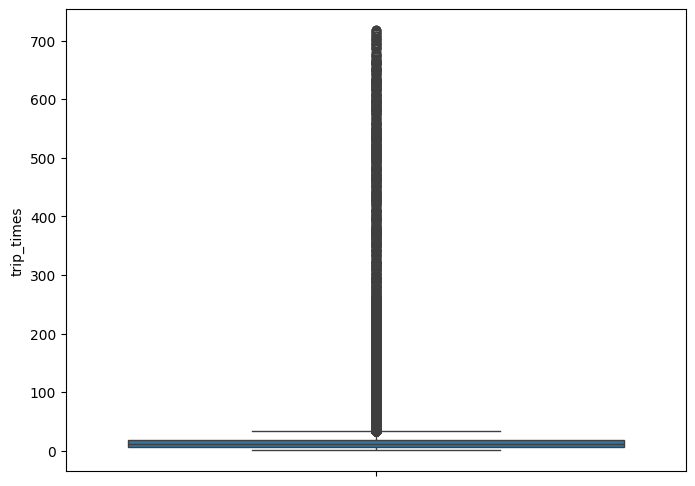

In [18]:
# Box-plot after removal of outliers
plt.figure(figsize = (8, 6))
sns.boxplot(y="trip_times", data = month_with_durations_modified)

## 1.3. Speed
check for any outliers in the data in terms of speed after trip duration outliers removed

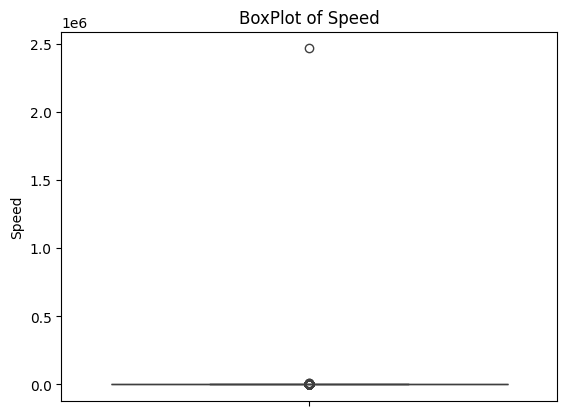

In [19]:
month_with_durations_modified['Speed'] = 60*(month_with_durations_modified['trip_distance']/month_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =month_with_durations_modified).set(title='BoxPlot of Speed')
plt.show()

In [20]:
# Calculating speed values at each percentile: 0,10,20,30,40,50,60,70,80,90,100
var = month_with_durations_modified["Speed"].values
var = np.sort(var,axis = None)
for i in range(0,100,10):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 6.404907975460122
20 percentile value is 7.65137614678899
30 percentile value is 8.625
40 percentile value is 9.542168674698795
50 percentile value is 10.514285714285714
60 percentile value is 11.644204851752022
70 percentile value is 13.119305856832971
80 percentile value is 15.406113537117903
90 percentile value is 20.291845493562228
100 percentile value is  2466486.923076923


In [21]:
# Calculating speed values at each percentile: 90,91,92,93,94,95,96,97,98,99,100
var = month_with_durations_modified["Speed"].values
var = np.sort(var,axis = None)
for i in range(90,100):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 20.291845493562228
91 percentile value is 21.13563829787234
92 percentile value is 22.0891161431702
93 percentile value is 23.16774193548387
94 percentile value is 24.402366863905325
95 percentile value is 25.84685367702805
96 percentile value is 27.631578947368425
97 percentile value is 29.866666666666667
98 percentile value is 32.75037821482602
99 percentile value is 36.90756302521008
100 percentile value is  2466486.923076923


In [22]:
# Calculating speed values at each percentile: 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
var = month_with_durations_modified["Speed"].values
var = np.sort(var,axis = None)
for i in np.arange(0.0, 1.0, 0.1):
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 36.90756302521008
99.1 percentile value is 37.482071713147405
99.2 percentile value is 38.09014514896868
99.3 percentile value is 38.74871794871795
99.4 percentile value is 39.486850545221294
99.5 percentile value is 40.31999999999999
99.6 percentile value is 41.29900990099009
99.7 percentile value is 42.50322580645162
99.8 percentile value is 44.148908857509625
99.9 percentile value is 46.97802197802198
100 percentile value is  2466486.923076923


In [23]:
# Removing further outliers based on the 99.9th percentile value
month_with_durations_modified = month_with_duration[(month_with_duration.Speed > 0) & \
    (month_with_duration.Speed < 46.97)]

The avg speed in Newyork speed is 12.19 miles/hr, so a cab driver can travel 2 miles per 10 min on an average.
We will be using this observation in determining the time-bins and the regions.

## 1.4 Trip Distance

Checking if we have any outliers in the trip distance i.e negative values and extreme large values based on percentlie values of data.

<Axes: ylabel='trip_distance'>

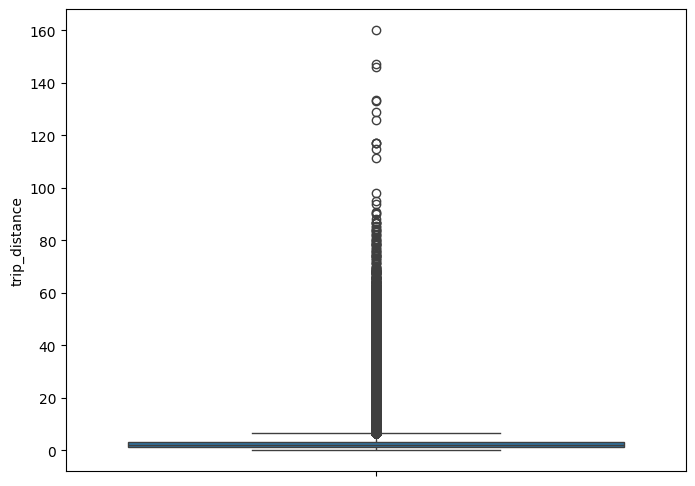

In [24]:
# Let's try if there are any outliers in trip distances
# Box-plot showing outliers in trip-distance values

plt.figure(figsize = (8, 6))
sns.boxplot(y = "trip_distance", data = month_with_durations_modified)

In [25]:
# Calculating trip distance values at each percentile: 0,10,20,30,40,50,60,70,80,90,100
var = month_with_durations_modified["trip_distance"].values
var = np.sort(var,axis = None)
for i in range(0,100,10):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.7
20 percentile value is 0.97
30 percentile value is 1.2
40 percentile value is 1.49
50 percentile value is 1.8
60 percentile value is 2.2
70 percentile value is 2.78
80 percentile value is 3.83
90 percentile value is 7.5
100 percentile value is  160.02


In [26]:
# Now calculating for trip distance for 90-100 percentile.
var = month_with_durations_modified["trip_distance"].values
var = np.sort(var,axis = None)
for i in range(90,100):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])


90 percentile value is 7.5
91 percentile value is 8.3
92 percentile value is 9.07
93 percentile value is 9.8
94 percentile value is 10.7
95 percentile value is 12.0
96 percentile value is 14.9
97 percentile value is 17.25
98 percentile value is 18.25
99 percentile value is 19.61
100 percentile value is  160.02


In [27]:
# Calculating trip distance values at each percentile: 99 - 100 at 0.1 steps.
var = month_with_durations_modified["trip_distance"].values
var = np.sort(var,axis = None)
for i in np.arange(0.0, 1.0, 0.1):
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 19.61
99.1 percentile value is 19.84
99.2 percentile value is 20.1
99.3 percentile value is 20.39
99.4 percentile value is 20.68
99.5 percentile value is 21.0
99.6 percentile value is 21.41
99.7 percentile value is 22.01
99.8 percentile value is 23.2
99.9 percentile value is 26.59
100 percentile value is  160.02


In [28]:
month_with_durations_modified=month_with_duration[(month_with_duration.trip_distance > 0) & \
    (month_with_duration.trip_distance < 27)]

<Axes: ylabel='trip_distance'>

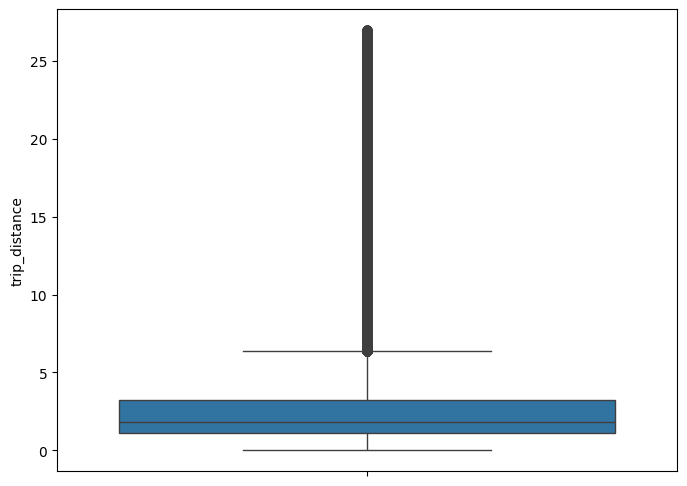

In [29]:
# After outliers the plot looks like
plt.figure(figsize = (8, 6))
sns.boxplot(y="trip_distance", data = month_with_durations_modified)

## 1.5 Total Amount
For finding outliers in the total amount payed by passengers we need to assume that the amount paid cannot be less than 0 or extremely large. Based on that we first box plot the current state of data.

<Axes: ylabel='total_amount'>

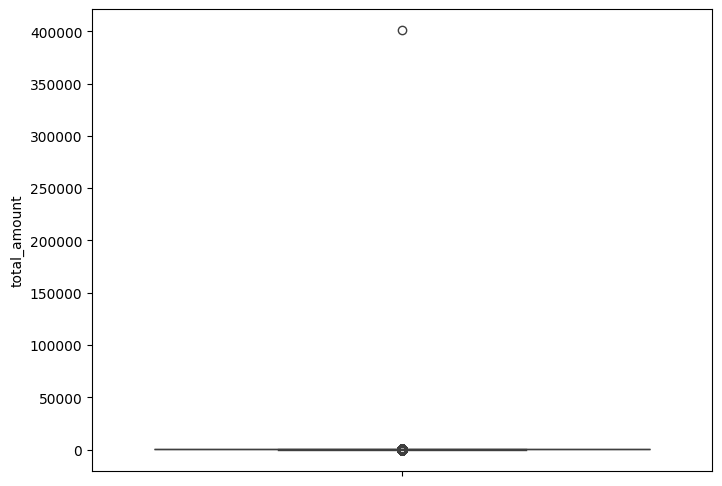

In [30]:
# Box-plot showing outliers in fare
plt.figure(figsize = (8, 6))
sns.boxplot(y="total_amount", data = month_with_durations_modified)

In [31]:
# Calculating total fare amount values at each percentile: 0 to 100.
var = month_with_durations_modified["total_amount"].values
var = np.sort(var,axis = None)
for i in range(0,100,10):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -600.3
10 percentile value is 9.8
20 percentile value is 11.16
30 percentile value is 12.35
40 percentile value is 13.56
50 percentile value is 14.8
60 percentile value is 16.56
70 percentile value is 18.96
80 percentile value is 22.88
90 percentile value is 34.55
100 percentile value is  401095.62


In [32]:
# Calculating total fare amount values at each percentile: 90 - 100
var = month_with_durations_modified["total_amount"].values
var = np.sort(var,axis = None)
for i in range(90,100):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 34.55
91 percentile value is 37.44
92 percentile value is 40.85
93 percentile value is 44.3
94 percentile value is 48.05
95 percentile value is 52.55
96 percentile value is 58.55
97 percentile value is 65.03
98 percentile value is 72.05
99 percentile value is 75.72
100 percentile value is  401095.62


In [33]:
# Calculating total fare amount values at each percentile: 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
var = month_with_durations_modified["total_amount"].values
var = np.sort(var,axis = None)
for i in np.arange(0.0, 1.0, 0.1):
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 75.72
99.1 percentile value is 75.85
99.2 percentile value is 77.35
99.3 percentile value is 78.56
99.4 percentile value is 79.6
99.5 percentile value is 80.87
99.6 percentile value is 81.12
99.7 percentile value is 84.19
99.8 percentile value is 90.06
99.9 percentile value is 102.75
100 percentile value is  401095.62


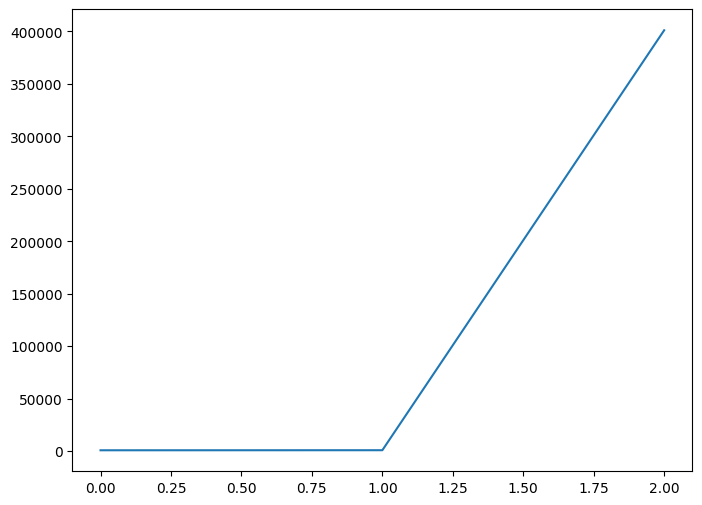

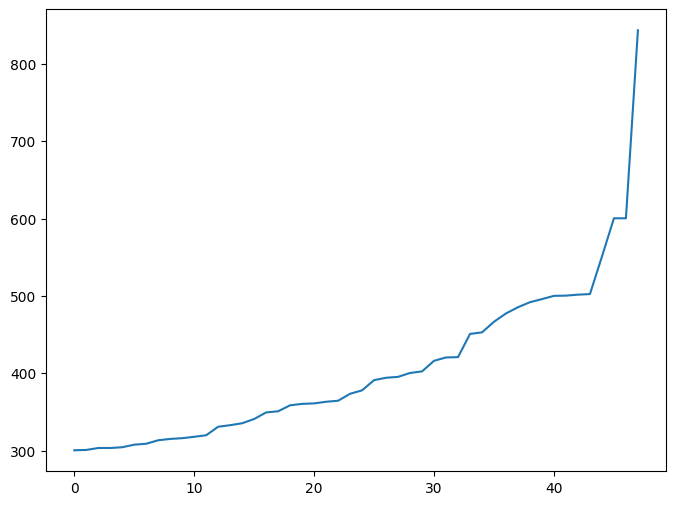

In [34]:
# A very sharp increase in fare values can be seen. Plotting last three total fare values
# And we can observe that there is a shared increase in the values
plt.figure(figsize = (8, 6))
plt.plot(var[-3:])
plt.show()

# We plot the last 50 values, excluding the last two values
plt.figure(figsize = (8, 6))
plt.plot(var[-50:-2])
plt.show()

## 1.6 Pickup and Dropoff latitude and Longitude

As per the ask, the lookup is bounded in Newyouk and nearby regions. And Newyork is bounded by the location cordinates (lat, long) - (40.5774, -74.15) & (40.9176,-73.7004).

- So any cordinates beyond this boundary of NY will be considered as outliler as we are only concerned with pickups which orginate within NY and dropoffs which are within NY.

In [35]:
!pip install geopandas

In [36]:
import pandas as pd
import geopandas as gpd

gdf = gpd.read_file("./taxi_zones.geojson")
gdf = gpd.GeoDataFrame(gdf)
gdf = gdf.to_crs("urn:ogc:def:crs:OGC:1.3:CRS84")

# Compute centroids
gdf["latitude"] = gdf.geometry.centroid.y
gdf["longitude"] = gdf.geometry.centroid.x
gdf.drop(['geometry'], axis=1, inplace=True)

gdf.to_csv('./taxi_zones_cord.csv')

Removing pickup and drop points greater than 263 and merging the coordinates with the main frame on location id.

In [37]:
month_with_durations_modified=month_with_duration[(month_with_duration.PULocationID > 0) & \
    (month_with_duration.PULocationID < 264)]
month_with_durations_modified=month_with_duration[(month_with_duration.DOLocationID > 0) & \
    (month_with_duration.DOLocationID < 264)]

In [38]:
month_with_durations_modified.head()

,passenger_count,trip_distance,total_amount,PULocationID,DOLocationID,trip_times,pickup_times,Speed
0,2.0,3.80,21.95,142,236,17.816667,1.640997e+09,12.797007
1,1.0,2.10,13.30,236,42,8.400000,1.640997e+09,15.000000
2,1.0,0.97,10.56,166,166,8.966667,1.640998e+09,6.490706
3,1.0,1.09,11.80,114,68,10.033333,1.640997e+09,6.518272
4,1.0,4.30,30.30,68,163,37.533333,1.640997e+09,6.873890


In [39]:
geo_data = pd.read_csv('./taxi_zones_cord.csv')
geo_data.drop(['Unnamed: 0', 'OBJECTID','Shape_Leng',	'Shape_Area', 'zone',	'borough'], axis=1, inplace=True)

In [40]:
month_with_durations_modified = month_with_durations_modified.merge(geo_data, left_on='PULocationID', right_on='LocationID', how='left')
month_with_durations_modified = month_with_durations_modified.merge(geo_data, left_on='DOLocationID', right_on='LocationID', how='left')

In [41]:
month_with_durations_modified.head()

,passenger_count,trip_distance,total_amount,PULocationID,DOLocationID,trip_times,pickup_times,Speed,LocationID_x,latitude_x,longitude_x,LocationID_y,latitude_y,longitude_y
0,2.0,3.80,21.95,142,236,17.816667,1.640997e+09,12.797007,142.0,40.773633,-73.981532,236.0,40.780436,-73.957012
1,1.0,2.10,13.30,236,42,8.400000,1.640997e+09,15.000000,236.0,40.780436,-73.957012,42.0,40.818258,-73.940772
2,1.0,0.97,10.56,166,166,8.966667,1.640998e+09,6.490706,166.0,40.809457,-73.961764,166.0,40.809457,-73.961764
3,1.0,1.09,11.80,114,68,10.033333,1.640997e+09,6.518272,114.0,40.728340,-73.997380,68.0,40.748428,-73.999917
4,1.0,4.30,30.30,68,163,37.533333,1.640997e+09,6.873890,68.0,40.748428,-73.999917,163.0,40.764421,-73.977569


In [42]:
month_with_durations_modified.rename(columns={'longitude_x': 'pickup_longitude', 'latitude_x': 'pickup_latitude', 'longitude_y': 'dropoff_longitude', 'latitude_y': 'dropoff_latitude'}, inplace=True)
month_with_durations_modified.drop(['LocationID_x', 	'LocationID_y'], axis=1, inplace=True)


In [43]:
month_with_durations_modified.head()

,passenger_count,trip_distance,total_amount,PULocationID,DOLocationID,trip_times,pickup_times,Speed,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,2.0,3.80,21.95,142,236,17.816667,1.640997e+09,12.797007,40.773633,-73.981532,40.780436,-73.957012
1,1.0,2.10,13.30,236,42,8.400000,1.640997e+09,15.000000,40.780436,-73.957012,40.818258,-73.940772
2,1.0,0.97,10.56,166,166,8.966667,1.640998e+09,6.490706,40.809457,-73.961764,40.809457,-73.961764
3,1.0,1.09,11.80,114,68,10.033333,1.640997e+09,6.518272,40.728340,-73.997380,40.748428,-73.999917
4,1.0,4.30,30.30,68,163,37.533333,1.640997e+09,6.873890,40.748428,-73.999917,40.764421,-73.977569


In [44]:
outlier_locations_pickup = month_with_durations_modified[((month_with_durations_modified.pickup_longitude <= -74.15) | (month_with_durations_modified.pickup_latitude <= 40.5774)| \
    (month_with_durations_modified.pickup_longitude >= -73.7004) | (month_with_durations_modified.pickup_latitude >= 40.9176))]
print("Number of Outlier Locations in Pickup:", len(outlier_locations_pickup))

Number of Outlier Locations in Pickup: 2032


In [45]:
outlier_locations_dropoff = month_with_durations_modified[((month_with_durations_modified.dropoff_longitude <= -74.15) | (month_with_durations_modified.dropoff_latitude <= 40.5774)| \
    (month_with_durations_modified.dropoff_longitude >= -73.7004) | (month_with_durations_modified.dropoff_latitude >= 40.9176))]
print("Number of Outlier Locations in Dropoff:", len(outlier_locations_dropoff))

Number of Outlier Locations in Dropoff: 18094


## 1.7 Removing outliers based on above analysis

In [8]:
def remove_outliers(new_frame):
  a = new_frame.shape[0]
  print('Number of Records: ', a)
  # Finding location outliers
  temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
    (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
    ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
    (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
  b = temp_frame.shape[0]
  print('Outliers coordinates lying outside NY boundaries: ', (a-b))
  # Finding Timing Outliers
  temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
  c = temp_frame.shape[0]
  print('Outliers from trip time analysis: ', (a-c))
  # Finding Speed Outliers
  temp_frame = new_frame[(new_frame.Speed >= 0) & (new_frame.Speed < 46.97)]
  d = temp_frame.shape[0]
  print('Outliers from speed analysis ', (a-d))
  # Finding trip distance Outliers
  temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 27)]
  e = temp_frame.shape[0]
  print('Outliers from distance analysis ', (a-e))
  # Finding Fare outliers
  temp_frame = new_frame[(new_frame.total_amount < 1000) & (new_frame.total_amount > 0)]
  f = temp_frame.shape[0]
  print('Outliers from fare anlaysis ', (a-f))

  new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
        (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
        ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
        (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
  new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
  new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 27)]
  new_frame = new_frame[(new_frame.Speed < 46.97) & (new_frame.Speed > 0)]
  new_frame = new_frame[(new_frame.total_amount < 1000) & (new_frame.total_amount > 0)]

  print ("Total outliers removed", a-new_frame.shape[0])
  return new_frame


In [9]:
geo_data = pd.read_csv('./taxi_zones_cord.csv')
geo_data.drop(['Unnamed: 0', 'OBJECTID','Shape_Leng',	'Shape_Area', 'zone',	'borough'], axis=1, inplace=True)

In [10]:
file_pattern = './train/yellow_tripdata_2022-*.parquet'
month = dd.read_parquet(file_pattern)
month.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [11]:
month = month.merge(geo_data, left_on='PULocationID', right_on='LocationID', how='left')
month = month.merge(geo_data, left_on='DOLocationID', right_on='LocationID', how='left')
month = month.rename(columns={'longitude_x': 'pickup_longitude', 'latitude_x': 'pickup_latitude', 'longitude_y': 'dropoff_longitude', 'latitude_y': 'dropoff_latitude'})
month = month.drop(['LocationID_x', 	'LocationID_y'], axis=1)
month = month.dropna()
month.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,...,3.65,0.0,0.3,21.95,2.5,0.0,40.773633,-73.981532,40.780436,-73.957012
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,...,4.00,0.0,0.3,13.30,0.0,0.0,40.780436,-73.957012,40.818258,-73.940772
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,...,1.76,0.0,0.3,10.56,0.0,0.0,40.809457,-73.961764,40.809457,-73.961764
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,...,0.00,0.0,0.3,11.80,2.5,0.0,40.728340,-73.997380,40.748428,-73.999917
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,...,3.00,0.0,0.3,30.30,2.5,0.0,40.748428,-73.999917,40.764421,-73.977569


In [12]:
month_with_duration = return_with_trip_times(month)
month_with_duration.head()

,passenger_count,trip_distance,total_amount,PULocationID,DOLocationID,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_times,pickup_times,Speed
0,2.0,3.80,21.95,142,236,-73.981532,40.773633,-73.957012,40.780436,17.816667,1.640997e+09,12.797007
1,1.0,2.10,13.30,236,42,-73.957012,40.780436,-73.940772,40.818258,8.400000,1.640997e+09,15.000000
2,1.0,0.97,10.56,166,166,-73.961764,40.809457,-73.961764,40.809457,8.966667,1.640998e+09,6.490706
3,1.0,1.09,11.80,114,68,-73.997380,40.728340,-73.999917,40.748428,10.033333,1.640997e+09,6.518272
4,1.0,4.30,30.30,68,163,-73.999917,40.748428,-73.977569,40.764421,37.533333,1.640997e+09,6.873890


In [13]:
print('Removing outliers in the traning data')
cleaned_data = remove_outliers(month_with_duration)
print('Fraction of data points which remained after removing outliers ',
      float(len(cleaned_data)) / len(month_with_duration))


Removing outliers in the traning data
Number of Records:  8645892
Outliers coordinates lying outside NY boundaries:  18550
Outliers from trip time analysis:  9389
Outliers from speed analysis  10721
Outliers from distance analysis  87733
Outliers from fare anlaysis  48164
Total outliers removed 163372
Fraction of data points which remained after removing outliers  0.9811040896647796


# 2. Data Preparation
## 2.1. Clustering/Segmentation
- While clustering, the inter-cluster distance for considering 2 clusters to be in the vicinity of each other is set as **2 miles**.
- In section 1.4, we observed that on an average, a cabbie can cover 2 miles in approximately 10 mins, and since, 2 miles is an acceptable distance to find more #pickups, hence, we have set the 2 miles threshold.
- We need to choose number of clusters so that, there are more number of cluster regions that are close to any cluster center and make sure that the minimum inter-cluster distance should not be very less.

In [14]:

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression

In [18]:
# Function to calculate the minimum distance between cluster centers
def calculate_min_distance(cluster_centers):
    min_dist = 1000  # Initial large value for minimum distance
    for i in range(len(cluster_centers)):
        for j in range(len(cluster_centers)):
            if j != i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],
                                                         cluster_centers[j][0], cluster_centers[j][1])
                # Convert distance from meters to miles
                min_dist = min(min_dist, distance / (1.60934 * 1000))
    return min_dist

# Function to find clusters and analyze cluster distances
def analyze_clusters(increment_range, coords):
    neighbours = []  # Store number of clusters within and outside vicinity
    for increment in increment_range:
        kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000, random_state=42).fit(coords)
        cluster_centers = kmeans.cluster_centers_
        cluster_len = len(cluster_centers)
        nice_points = []  # Store number of clusters within vicinity
        for i in range(cluster_len):
            nice_points.append(np.sum([1 for j in range(cluster_len) if j != i and
                                       gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],
                                                                     cluster_centers[j][0], cluster_centers[j][1]) / (1.60934 * 1000) <= 2]))
        neighbours.append(nice_points)
        min_dist = calculate_min_distance(cluster_centers)
        print("On choosing a cluster size of:", increment, "\nAvg. #Clusters within the vicinity (i.e. intercluster-distance < 2):",
              np.ceil(np.mean(nice_points)), "\nAvg. #Clusters outside the vicinity (i.e. intercluster-distance > 2):",
              np.ceil(cluster_len - np.mean(nice_points)), "\nMin inter-cluster distance:", min_dist, "\n")
    return neighbours

# Define the range of cluster sizes to try
increment_range = range(10, 100, 10)

# Perform clustering and analyze cluster distances
coords = cleaned_data[['pickup_latitude', 'pickup_longitude']].values
neighbours = analyze_clusters(increment_range, coords)

On choosing a cluster size of: 10 
Avg. #Clusters within the vicinity (i.e. intercluster-distance < 2): 3.0 
Avg. #Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance: 0.8230161747301091 

On choosing a cluster size of: 20 
Avg. #Clusters within the vicinity (i.e. intercluster-distance < 2): 6.0 
Avg. #Clusters outside the vicinity (i.e. intercluster-distance > 2): 15.0 
Min inter-cluster distance: 0.5124916114498591 

On choosing a cluster size of: 30 
Avg. #Clusters within the vicinity (i.e. intercluster-distance < 2): 11.0 
Avg. #Clusters outside the vicinity (i.e. intercluster-distance > 2): 20.0 
Min inter-cluster distance: 0.18076367749492658 

On choosing a cluster size of: 40 
Avg. #Clusters within the vicinity (i.e. intercluster-distance < 2): 13.0 
Avg. #Clusters outside the vicinity (i.e. intercluster-distance > 2): 28.0 
Min inter-cluster distance: 0.30987689292348597 

On choosing a cluster size of: 50 
Avg. #Clusters within the 

# Baseline Model